In [1]:
%matplotlib inline
import pennylane as qml
import torch

import qiskit
import qiskit.providers.aer.noise as noise
#from pennylane_cirq import ops as cirq_ops
# from pennylane_ionq import ops # not used right now, but for future
from pennylane import numpy as np # autograd compatible numpy
from pennylane.numpy import pi 
import matplotlib.pyplot as plt
from torch.autograd.functional import hessian, jacobian
plt.rcParams['figure.facecolor'] = 'w'
%precision %0.4f   
#control display precision

if True:    #for collapsing following block in Spyder or any editor
    import seaborn as sns
    
    sns.set_color_codes("deep"); sns.set_context("paper"); sns.set_style("ticks")
    STYLE_DICT = dict.fromkeys(['axes.labelsize', 'xtick.labelsize', 'ytick.labelsize', 'axes.titlesize'], 'medium')
    STYLE_DICT.update({'font.size': 18, 'figure.dpi':150, 'image.cmap': 'plasma'})
    STYLE_DICT.update(dict.fromkeys(['ytick.direction', 'xtick.direction'], 'in'))
    STYLE_DICT.update(dict.fromkeys(['xtick.major.width', 'ytick.major.width', 'axes.linewidth'], .5))
    plt.rcParams.update(STYLE_DICT)

In [2]:
num_wires = 5
N_wires = num_wires
param_shape = qml.StronglyEntanglingLayers.shape(n_layers=3, n_wires=N_wires) #
weights = torch.rand(param_shape)
dev = qml.device("default.qubit", wires=num_wires)


def fidelity(cur_state, target_state): # Inner product 
    # target_state = torch.Tensor(target_state)
    # cur_state = torch.Tensor(target_state)
    return torch.real(torch.dot(torch.conj(cur_state), target_state))

def norm(state): # normalize 
    # state = torch.Tensor(state)
    return state / torch.sqrt((torch.dot(torch.conj(state), state)))

def phi_parameterization(params): # restrict phase angles to -pi to pi
    return torch.clip(params, -1.5*pi, 1.5*pi) #np is okay since the params input should be a pytorch array




0: ──Rot(0.29,0.18,0.46)─╭●──────────╭X──Rot(0.16,0.04,0.84)─╭●───────╭X──Rot(0.54,0.42,0.03)
1: ──Rot(0.83,0.59,0.21)─╰X─╭●───────│───Rot(0.28,0.02,0.11)─│──╭●────│──╭X──────────────────
2: ──Rot(0.44,0.81,0.81)────╰X─╭●────│───Rot(0.30,0.54,0.39)─╰X─│──╭●─│──│───────────────────
3: ──Rot(0.98,1.00,0.17)───────╰X─╭●─│───Rot(0.65,0.28,0.10)────╰X─│──╰●─│───────────────────
4: ──Rot(0.21,0.45,0.04)──────────╰X─╰●──Rot(0.43,0.25,0.53)───────╰X────╰●──────────────────

───────────────────────╭●────╭X───────┤  State
───Rot(0.36,0.33,0.36)─│──╭●─│──╭X────┤  State
───Rot(0.94,0.80,0.58)─│──│──╰●─│──╭X─┤  State
───Rot(0.86,0.52,0.12)─╰X─│─────╰●─│──┤  State
───Rot(0.43,0.87,0.90)────╰X───────╰●─┤  State
(<Figure size 3150x900 with 1 Axes>, <Axes: >)
tensor([ 0.4449-0.2846j,  0.0837-0.0974j,  0.3142+0.1197j,  0.0251+0.0242j,
        -0.0247+0.0350j,  0.2297+0.1105j, -0.0524-0.0657j, -0.1149+0.0871j,
        -0.0079+0.1296j, -0.0433+0.0081j,  0.2358+0.0313j,  0.0619-0.0169j,
         0.1230-0.0

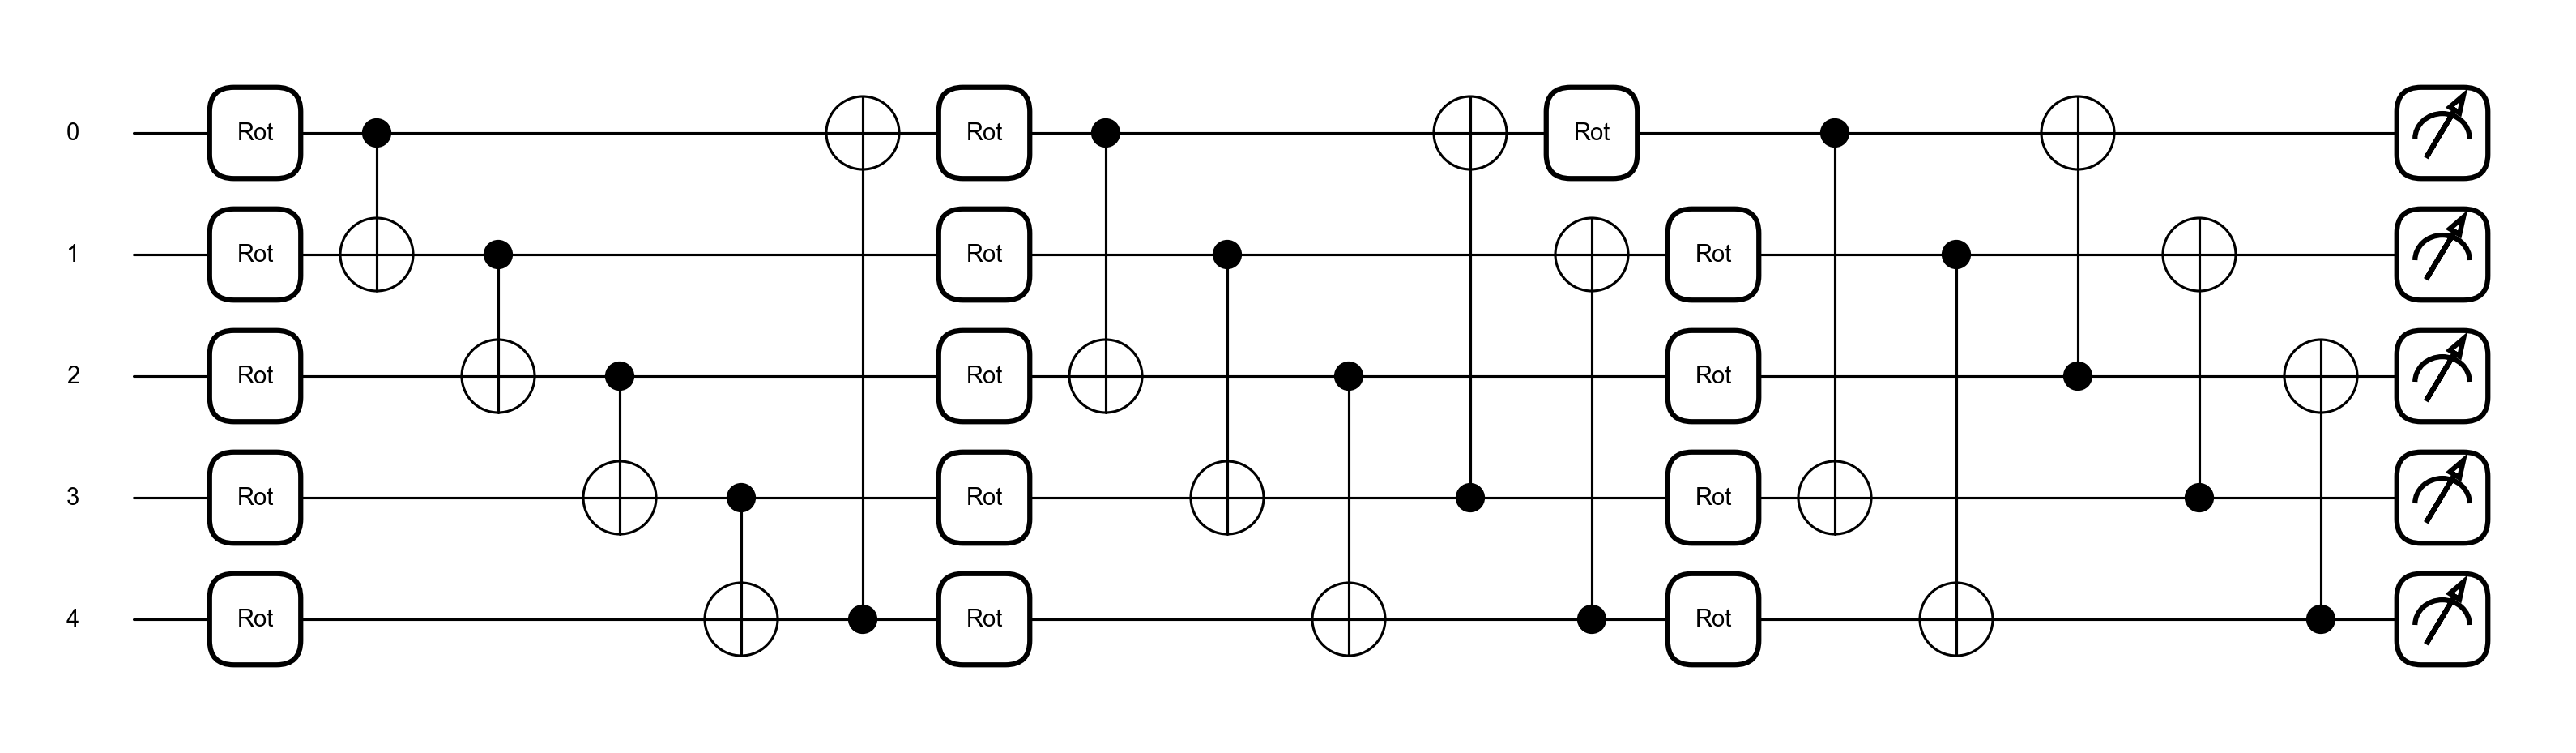

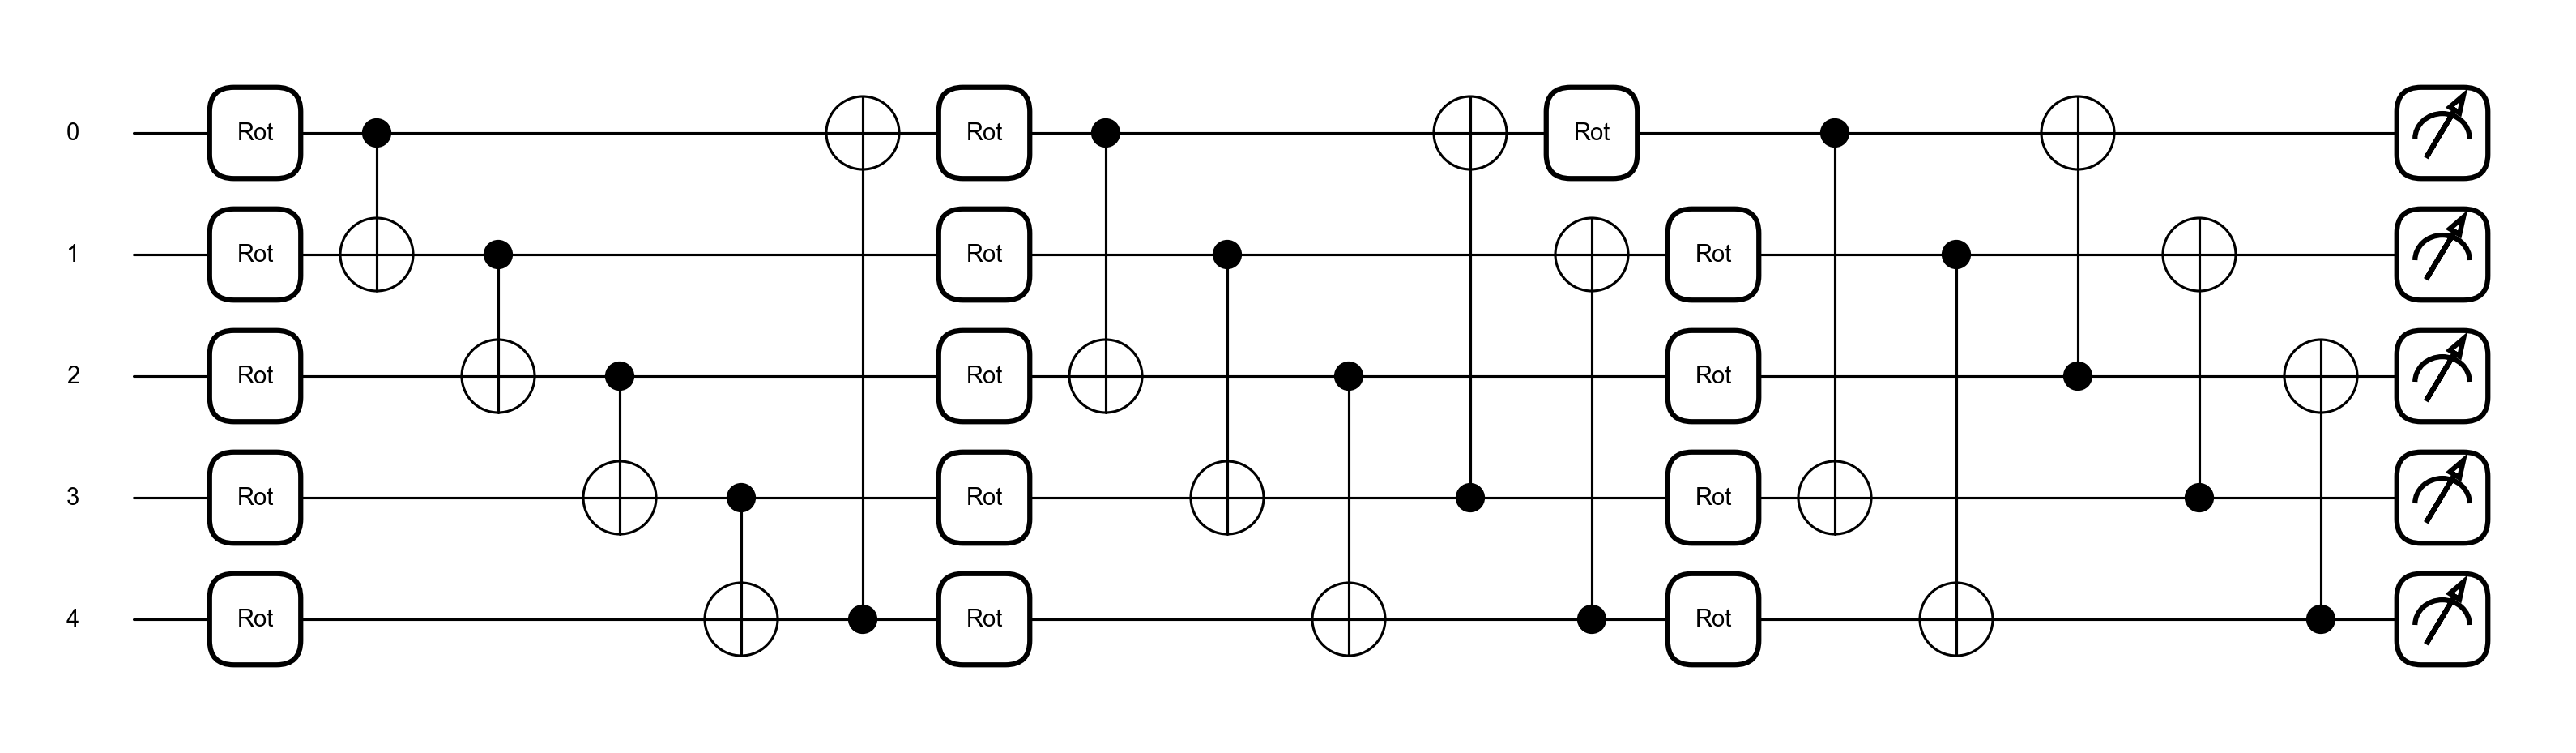

In [3]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def circuit(phi_arr):
    qml.RZ(phi_arr[0], wires=0)
    qml.RX(pi/2, wires=0)
    qml.PhaseShift(phi_arr[1], wires=0)
    qml.RX(pi/2, wires=0)
    qml.PhaseShift(phi_arr[2], wires=0)
    
    qml.RZ(phi_arr[3], wires=1)
    qml.RX(pi/2, wires=1)
    qml.PhaseShift(phi_arr[4], wires=1)
    qml.RX(pi/2, wires=1)
    qml.PhaseShift(phi_arr[5], wires=1)
    
    qml.RZ(phi_arr[6], wires=2)
    qml.RX(pi/2, wires=2)
    qml.PhaseShift(phi_arr[7], wires=2)
    qml.RX(pi/2, wires=2)
    qml.PhaseShift(phi_arr[8], wires=2)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    return qml.state()

@qml.qnode(dev, interface='torch', diff_method="backprop")
def circuit_random_layers(parameters, noise_amp=0.00):
    # rnd_gen = np.random.default_rng()
    # rnd_phases = rnd_gen.uniform(-0.5, 0.5, size=(parameters.shape))*noise_amp*2*pi
    rnd_phases = (torch.rand(parameters.shape) - 0.50) * noise_amp*2*pi
    qml.StronglyEntanglingLayers(weights=parameters+rnd_phases, wires=range(N_wires))
    return qml.state()
print(qml.draw(circuit_random_layers, expansion_strategy='device')(weights))
print(qml.draw_mpl(circuit_random_layers, expansion_strategy='device')(weights))
print(circuit_random_layers(weights))


@qml.qnode(dev, interface='torch', diff_method="backprop")
def circuit_random_layers_no_noise(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(N_wires))
    return qml.state()
print(qml.draw(circuit_random_layers_no_noise, expansion_strategy='device')(weights))
print(qml.draw_mpl(circuit_random_layers_no_noise, expansion_strategy='device')(weights))

In [5]:

ghz_list = [1] + [0.0]*(2**N_wires - 2) + [-1] # GHZ state
w_list = [0]*(2**N_wires); 
for ii in range(N_wires):
    w_list[2**ii] = 1; #1/torch.sqrt(N_wires) # W state
target_state = norm(torch.tensor(ghz_list, dtype=torch.complex128)) # W state
Nshots = 2 # Number of shots each with a diff initial phase angles
steps = 50 # Number of steps per shot
eta = 0.09 # learning rate
phi_len = torch.prod(torch.tensor(param_shape))
I = torch.eye(phi_len, requires_grad=False); delta = 1.50; alpha = 5*eta
# random_seeds = range(101, 25000, 33) # construct a large array of seeds > Nshots in length
random_seeds = range(14, 25000, 35) # construct a large array of seeds > Nshots in length

phi_arr_best = torch.zeros(phi_len, requires_grad=False)
costs_final = 1
cost_history_best = []
noise_amplitude = 0.000

def cost_fn_no_noise(phi_arr): # define local cost function with only parameters as phase angles
    return 1. - \
        fidelity(circuit_random_layers_no_noise(phi_parameterization(phi_arr.reshape(param_shape))), target_state)

def cost_fn_noisy(phi_arr): # define local cost function with only parameters as phase angles
    return 1. - \
        fidelity(circuit_random_layers(phi_parameterization(phi_arr.reshape(param_shape)), noise_amp=noise_amplitude), target_state)


for ii in range (Nshots):
    print(f"\nEpoch {ii}")
    torch.manual_seed(random_seeds[ii])
    phi_arr0 = torch.randn(phi_len, requires_grad=True)
    phi_arr = phi_arr0
    K = torch.zeros((phi_len, phi_len), requires_grad=False)
    cost_history = []

    optimizer = torch.optim.SGD([phi_arr], lr=eta*10.5)
    # optimizer = torch.optim.LBFGS([phi_arr], lr=eta/3, tolerance_change=1e-13, tolerance_grad=1e-13)
    def closure():
        print(cost_fn_noisy(phi_arr))
        optimizer.zero_grad()
        loss = cost_fn_noisy(phi_arr)
        loss.backward()
        return loss

    for jj in range(steps):
        optimizer.step(closure)
        cost = cost_fn_noisy(phi_arr)
        # -------- Following lines for IPG----------
    # for jj in range(steps):
    #     hess = hessian(cost_fn_noisy, phi_arr)
    #     K = K   -   alpha * (torch.matmul(hess, K) - I)
    #     g = jacobian(cost_fn_noisy, phi_arr)
    #     phi_arr = phi_arr - delta*torch.matmul(K, g)
    #     cost = cost_fn_noisy(phi_arr)
        #--------Above lines for IPG---------------

        # Next line is for running built-in optimizers like GD, Adam, Nesterov
        # phi_arr, cost = opt.step_and_cost(cost_fn_noisy, phi_arr, grad_fn=grad_fn)
        if (jj+1) % (steps//5) == 0 or jj==steps-1:
            print(f"Step {jj+1:3d}\t Cost_L = {cost:0.7f}")
        cost_history.append(cost.clone().detach())
    if ii == 0:
        costs_final = cost_history[-1]
        cost_history_best = np.copy(cost_history)
        phi_arr_best = phi_arr.clone().detach()
    if costs_final > cost_history[-1]:
        costs_final = cost_history[-1]
        cost_history_best = np.copy(cost_history)
        phi_arr_best = phi_arr.clone().detach()
SGD_best = np.copy(cost_history_best)
print(f"Best cost out of {Nshots} attempts: {np.mean(cost_history_best[steps*9//10:])}") # For noisy final costs, take a mean over last 10% of costs
print(f"Optimized phases (in $\pi$ units): {phi_arr_best/pi}")
torch.save(cost_history_best, f"costs_IPG_delta{delta}_alpha{alpha}.pt")


Epoch 0
tensor(0.9174, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7449, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6560, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6120, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5818, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5585, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5390, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5216, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5054, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4899, dtype=torch.float64, grad_fn=<RsubBackward1>)
Step  10	 Cost_L = 0.4745930
tensor(0.4746, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4593, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4438, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4283, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4127, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3975, dtype=torch.float64, grad_fn=<Rs